In [ ]:
!pip install contractions

import numpy as np 
import pandas as pd 
import string as st
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import contractions
import sklearn
import plotly.graph_objects as go
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

     |████████████████████████████████| 284 kB 4.8 MB/s 
     |████████████████████████████████| 321 kB 47.1 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85458 sha256=c8bb0e3a63153cbf8cdffffa4246df663bab4e9532718d74cbc808837c14b12c
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


# load raw dataset and prepare simple train and test predict dataset - SIMPLE

In [ ]:
raw = pd.read_csv('tripadvisor_hotel_reviews.csv')
raw.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
raw['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [ ]:
raw1 = raw

positive = [4, 5]
negative = [1, 2]
neutral = [3]

def sentiment(rating):
  if rating in positive:
    return 1
  elif rating in negative:
    return -1
  else:
    return 0

raw1['Sentiment'] = raw1['Rating'].apply(sentiment)
raw1.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,-1
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


In [ ]:
raw1['Rating'] = raw1['Rating'].astype(str)
raw1_rt1 = raw1[raw1['Rating'].isin(['1'])]
raw1_rt2 = raw1[raw1['Rating'].isin(['2'])]
raw1_rt3 = raw1[raw1['Rating'].isin(['3'])]
raw1_rt4 = raw1[raw1['Rating'].isin(['4'])]
raw1_rt5 = raw1[raw1['Rating'].isin(['5'])]

In [ ]:
rprep1_train = raw1_rt1.sample(n = 16, random_state = 2)
rprep2_train = raw1_rt2.sample(n = 16, random_state = 2)
rprep3_train = raw1_rt3.sample(n = 36, random_state = 2)
rprep4_train = raw1_rt4.sample(n = 16, random_state = 2)
rprep5_train = raw1_rt5.sample(n = 16, random_state = 2)
prepframelist_train = [rprep1_train, rprep2_train, rprep3_train, rprep4_train, rprep5_train]
simple_train_ready = pd.concat(prepframelist_train)

train_exclude = raw1[~raw1['Review'].isin(simple_train_ready['Review'])]

simple_train_ready = simple_train_ready.reset_index(drop=True)

In [ ]:
train_exclude['Rating'].value_counts()

5    9038
4    6023
3    2148
2    1777
1    1405
Name: Rating, dtype: int64

In [ ]:
train_exclude['Rating'] = train_exclude['Rating'].astype(str)
train_exclude_rt1 = train_exclude[train_exclude['Rating'].isin(['1'])]
train_exclude_rt2 = train_exclude[train_exclude['Rating'].isin(['2'])]
train_exclude_rt3 = train_exclude[train_exclude['Rating'].isin(['3'])]
train_exclude_rt4 = train_exclude[train_exclude['Rating'].isin(['4'])]
train_exclude_rt5 = train_exclude[train_exclude['Rating'].isin(['5'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
rprep1_test = train_exclude_rt1.sample(n = 3, random_state = 7)
rprep2_test = train_exclude_rt2.sample(n = 3, random_state = 7)
rprep3_test = train_exclude_rt3.sample(n = 8, random_state = 7)
rprep4_test = train_exclude_rt4.sample(n = 3, random_state = 7)
rprep5_test = train_exclude_rt5.sample(n = 3, random_state = 7)
prepframelist_test = [rprep1_test, rprep2_test, rprep3_test, rprep4_test, rprep5_test]

simple_test_master_ready = pd.concat(prepframelist_test)
simple_test_master_ready = simple_test_master_ready.reset_index(drop=True)

In [ ]:
simple_train_ready = simple_train_ready.drop(['Rating'], axis=1)
simple_train_ready.to_csv('train.csv', index=False)
simple_test_master_ready = simple_test_master_ready.drop(['Rating'], axis=1)
simple_test_master_ready.to_csv('test_master.csv', index=False)
simple_test_ready = simple_test_master_ready.drop(['Sentiment'], axis=1)
simple_test_ready.to_csv('test.csv', index=False)

In [ ]:
simple_train_ready.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


In [ ]:
simple_test_master_ready.head()

,Review,Sentiment
0,stay reservation sister hotel regencia colon a...,-1
1,"id stay motel 4 star, hahahaa, seen better mot...",-1
2,cramped noisy overrated husband just stayed ho...,-1
3,"reading reviews felt good idea expect, rooms d...",-1
4,"not 5 star, husband stayed paradisus 5 days 4 ...",-1


In [ ]:
simple_test_ready.head()

,Review
0,stay reservation sister hotel regencia colon a...
1,"id stay motel 4 star, hahahaa, seen better mot..."
2,cramped noisy overrated husband just stayed ho...
3,"reading reviews felt good idea expect, rooms d..."
4,"not 5 star, husband stayed paradisus 5 days 4 ..."


# data preprocessing

In [ ]:
train = pd.read_csv('train.csv')
test_prediction = pd.read_csv('test.csv')

In [ ]:
train.head(20)

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1
5,kicked parents decided great sister resort fam...,-1
6,"think trip bad, evening paradise sept 20/08 ma...",-1
7,"hated parador renter beware, villas not want b...",-1
8,open fedex account fedex following items parad...,-1
9,really awful hotel based reviews inclusion con...,-1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     100 non-null    object
 1   Sentiment  100 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [ ]:
train.describe()

,Sentiment
count,100.00000
mean,0.00000
std,0.80403
min,-1.00000
25%,-1.00000
50%,0.00000
75%,1.00000
max,1.00000


In [ ]:
fig = go.Figure([go.Bar(x=train.Sentiment.value_counts().index, y=train.Sentiment.value_counts().tolist(), width=0.75)])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values",
    width=500)
fig.show()

In [ ]:
test_prediction.head()

,Review
0,stay reservation sister hotel regencia colon a...
1,"id stay motel 4 star, hahahaa, seen better mot..."
2,cramped noisy overrated husband just stayed ho...
3,"reading reviews felt good idea expect, rooms d..."
4,"not 5 star, husband stayed paradisus 5 days 4 ..."


### 1. expand contractions

In [ ]:
train2 = train
train2['Review'] = train2['Review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
train2['Review'] = [' '.join(map(str, l)) for l in train2['Review']]
train2.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


### 2. case folding, lowercasing

In [ ]:
train3 = train2
train3["Review"] = train3["Review"].str.lower()
train3.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


### 3. remove number

In [ ]:
train4 = train3
train4['Review'] = train4['Review'].apply(lambda x: re.sub("[0-9]", " ", x))
train4.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june - power w...",-1
3,service slower public transport star prices ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


### 4. punctuation removal

In [ ]:
train5 = train4
train5['Review'] = train5['Review'].apply(lambda x: re.sub('[%s]' % re.escape(st.punctuation), '' , x))
train5.head()

,Review,Sentiment
0,worst vacation just returned punta cana disapp...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power wat...,-1
3,service slower public transport star prices ...,-1
4,surround sound air conditionersyikes husband w...,-1


### 5. stopwords removal

In [ ]:
nltk.download('stopwords')
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [ ]:
train6 = train5
train6['Review'] = train6['Review'].apply(lambda text: remove_stopwords(text))
train6.head()

,Review,Sentiment
0,worst vacation returned punta cana disappointm...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power water ...,-1
3,service slower public transport star prices st...,-1
4,surround sound air conditionersyikes husband w...,-1


### 6. lemmatization

In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
train7 = train6
train7['Review'] = train7['Review'].apply(lambda text: lemmatize_words(text))
train7.head()

,Review,Sentiment
0,worst vacation returned punta cana disappointm...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power water ...,-1
3,service slower public transport star price sta...,-1
4,surround sound air conditionersyikes husband w...,-1


### finishing preprocess

In [ ]:
train7.to_csv('train_preproc_done.csv', index=False)

# processing

In [ ]:
train_proc = pd.read_csv('train_preproc_done.csv')
train_proc.head(20)

,Review,Sentiment
0,worst vacation returned punta cana disappointm...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power water ...,-1
3,service slower public transport star price sta...,-1
4,surround sound air conditionersyikes husband w...,-1
5,kicked parent decided great sister resort fami...,-1
6,think trip bad evening paradise sept marble fl...,-1
7,hated parador renter beware villa want believe...,-1
8,open fedex account fedex following item paradi...,-1
9,really awful hotel based review inclusion cond...,-1


## tf-idf

In [ ]:
docs = list(train_proc['Review'])
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 20000)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [ ]:
X = tfidf_vectorizer_vectors.toarray()
Y = train_proc['Sentiment']

In [ ]:
len(X[0])

3219

#### split dataset to train and validation

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=51)

## classification

In [ ]:
RANDOM_SEED=51

### decision tree classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.3


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.20      0.20      0.20         5
     neutral       0.20      0.33      0.25         6
    negative       0.60      0.33      0.43         9

    accuracy                           0.30        20
   macro avg       0.33      0.29      0.29        20
weighted avg       0.38      0.30      0.32        20



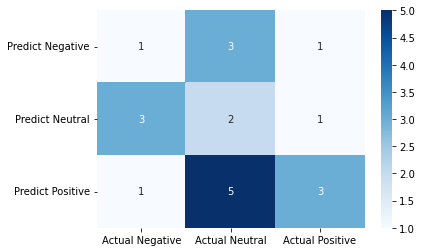

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### naive bayes classifier

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,gnb.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,gnb.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.4


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.18      0.40      0.25         5
     neutral       0.60      0.50      0.55         6
    negative       0.75      0.33      0.46         9

    accuracy                           0.40        20
   macro avg       0.51      0.41      0.42        20
weighted avg       0.56      0.40      0.43        20



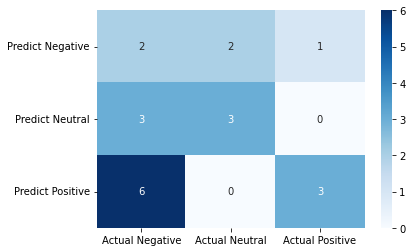

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### logistic regression

In [ ]:
lr = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,lr.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,lr.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.35


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.50      0.60      0.55         5
     neutral       0.31      0.67      0.42         6
    negative       0.00      0.00      0.00         9

    accuracy                           0.35        20
   macro avg       0.27      0.42      0.32        20
weighted avg       0.22      0.35      0.26        20



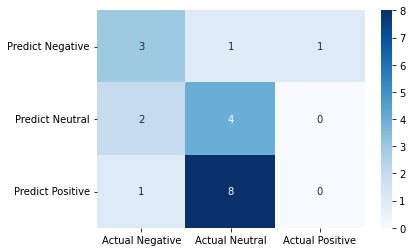

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### random forest classifier

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,clf.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,clf.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.35


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.40      0.40      0.40         5
     neutral       0.27      0.50      0.35         6
    negative       0.50      0.22      0.31         9

    accuracy                           0.35        20
   macro avg       0.39      0.37      0.35        20
weighted avg       0.41      0.35      0.34        20



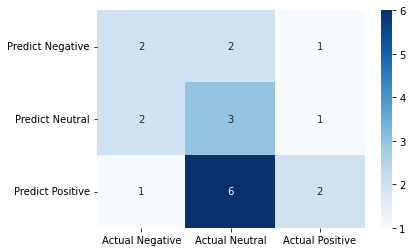

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

# -------------------------------------------------------------

# load raw dataset and prepare simple train and test predict dataset - MANY

In [ ]:
raw = pd.read_csv('tripadvisor_hotel_reviews.csv')
raw.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
raw['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [ ]:
raw1 = raw

positive = [4, 5]
negative = [1, 2]
neutral = [3]

def sentiment(rating):
  if rating in positive:
    return 1
  elif rating in negative:
    return -1
  else:
    return 0

raw1['Sentiment'] = raw1['Rating'].apply(sentiment)
raw1.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,-1
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


In [ ]:
raw1['Rating'] = raw1['Rating'].astype(str)
raw1_rt1 = raw1[raw1['Rating'].isin(['1'])]
raw1_rt2 = raw1[raw1['Rating'].isin(['2'])]
raw1_rt3 = raw1[raw1['Rating'].isin(['3'])]
raw1_rt4 = raw1[raw1['Rating'].isin(['4'])]
raw1_rt5 = raw1[raw1['Rating'].isin(['5'])]

In [ ]:
rprep1_train = raw1_rt1.sample(n = 1000, random_state = 2)
rprep2_train = raw1_rt2.sample(n = 1000, random_state = 2)
rprep3_train = raw1_rt3.sample(n = 2000, random_state = 2)
rprep4_train = raw1_rt4.sample(n = 1000, random_state = 2)
rprep5_train = raw1_rt5.sample(n = 1000, random_state = 2)
prepframelist_train = [rprep1_train, rprep2_train, rprep3_train, rprep4_train, rprep5_train]
simple_train_ready = pd.concat(prepframelist_train)

train_exclude = raw1[~raw1['Review'].isin(simple_train_ready['Review'])]

simple_train_ready = simple_train_ready.reset_index(drop=True)

In [ ]:
train_exclude['Rating'].value_counts()

5    8054
4    5039
2     793
1     421
3     184
Name: Rating, dtype: int64

In [ ]:
train_exclude['Rating'] = train_exclude['Rating'].astype(str)
train_exclude_rt1 = train_exclude[train_exclude['Rating'].isin(['1'])]
train_exclude_rt2 = train_exclude[train_exclude['Rating'].isin(['2'])]
train_exclude_rt3 = train_exclude[train_exclude['Rating'].isin(['3'])]
train_exclude_rt4 = train_exclude[train_exclude['Rating'].isin(['4'])]
train_exclude_rt5 = train_exclude[train_exclude['Rating'].isin(['5'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
rprep1_test = train_exclude_rt1.sample(n = 3, random_state = 7)
rprep2_test = train_exclude_rt2.sample(n = 3, random_state = 7)
rprep3_test = train_exclude_rt3.sample(n = 8, random_state = 7)
rprep4_test = train_exclude_rt4.sample(n = 3, random_state = 7)
rprep5_test = train_exclude_rt5.sample(n = 3, random_state = 7)
prepframelist_test = [rprep1_test, rprep2_test, rprep3_test, rprep4_test, rprep5_test]

simple_test_master_ready = pd.concat(prepframelist_test)
simple_test_master_ready = simple_test_master_ready.reset_index(drop=True)

In [ ]:
simple_train_ready = simple_train_ready.drop(['Rating'], axis=1)
simple_train_ready.to_csv('train.csv', index=False)
simple_test_master_ready = simple_test_master_ready.drop(['Rating'], axis=1)
simple_test_master_ready.to_csv('test_master.csv', index=False)
simple_test_ready = simple_test_master_ready.drop(['Sentiment'], axis=1)
simple_test_ready.to_csv('test.csv', index=False)

In [ ]:
simple_train_ready.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


In [ ]:
simple_test_master_ready.head()

,Review,Sentiment
0,stay away hotel experience hotel great disappo...,-1
1,poor management husband staying summerfield su...,-1
2,"dump, hotel did good reviews stay, just checke...",-1
3,confusing disorganized property travelers real...,-1
4,"germans, fantastic resort just expected great ...",-1


In [ ]:
simple_test_ready.head()

,Review
0,stay away hotel experience hotel great disappo...
1,poor management husband staying summerfield su...
2,"dump, hotel did good reviews stay, just checke..."
3,confusing disorganized property travelers real...
4,"germans, fantastic resort just expected great ..."


# data preprocessing

In [ ]:
train = pd.read_csv('train.csv')
test_prediction = pd.read_csv('test.csv')

In [ ]:
train.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     6000 non-null   object
 1   Sentiment  6000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 93.9+ KB


In [ ]:
train.describe()

,Sentiment
count,6000.000000
mean,0.000000
std,0.816565
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
fig = go.Figure([go.Bar(x=train.Sentiment.value_counts().index, y=train.Sentiment.value_counts().tolist(), width=0.75)])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values",
    width=500)
fig.show()

In [ ]:
test_prediction.head()

,Review
0,stay away hotel experience hotel great disappo...
1,poor management husband staying summerfield su...
2,"dump, hotel did good reviews stay, just checke..."
3,confusing disorganized property travelers real...
4,"germans, fantastic resort just expected great ..."


### 1. expand contractions

In [ ]:
train2 = train
train2['Review'] = train2['Review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
train2['Review'] = [' '.join(map(str, l)) for l in train2['Review']]
train2.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


### 2. case folding, lowercasing

In [ ]:
train3 = train2
train3["Review"] = train3["Review"].str.lower()
train3.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


### 3. remove number

In [ ]:
train4 = train3
train4['Review'] = train4['Review'].apply(lambda x: re.sub("[0-9]", " ", x))
train4.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june - power w...",-1
3,service slower public transport star prices ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


### 4. punctuation removal

In [ ]:
train5 = train4
train5['Review'] = train5['Review'].apply(lambda x: re.sub('[%s]' % re.escape(st.punctuation), '' , x))
train5.head()

,Review,Sentiment
0,worst vacation just returned punta cana disapp...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power wat...,-1
3,service slower public transport star prices ...,-1
4,surround sound air conditionersyikes husband w...,-1


### 5. stopwords removal

In [ ]:
nltk.download('stopwords')
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [ ]:
train6 = train5
train6['Review'] = train6['Review'].apply(lambda text: remove_stopwords(text))
train6.head()

,Review,Sentiment
0,worst vacation returned punta cana disappointm...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power water ...,-1
3,service slower public transport star prices st...,-1
4,surround sound air conditionersyikes husband w...,-1


### 6. lemmatization

In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train7 = train6
train7['Review'] = train7['Review'].apply(lambda text: lemmatize_words(text))
train7.head()

,Review,Sentiment
0,worst vacation returned punta cana disappointm...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power water ...,-1
3,service slower public transport star price sta...,-1
4,surround sound air conditionersyikes husband w...,-1


### finishing preprocess

In [ ]:
train7.to_csv('train_preproc_done.csv', index=False)

# processing

In [ ]:
train_proc = pd.read_csv('train_preproc_done.csv')
train_proc.head()

,Review,Sentiment
0,worst vacation returned punta cana disappointm...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power water ...,-1
3,service slower public transport star price sta...,-1
4,surround sound air conditionersyikes husband w...,-1


## tf-idf

In [ ]:
docs = list(train_proc['Review'])
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 20000)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [ ]:
X = tfidf_vectorizer_vectors.toarray()
Y = train_proc['Sentiment']

In [ ]:
len(X[0])

20000

#### split dataset to train and validation

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=51)

## classification

In [ ]:
RANDOM_SEED=51

### decision tree classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.5267


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.60      0.58      0.59       407
     neutral       0.40      0.40      0.40       388
    negative       0.58      0.59      0.58       405

    accuracy                           0.53      1200
   macro avg       0.52      0.52      0.52      1200
weighted avg       0.53      0.53      0.53      1200



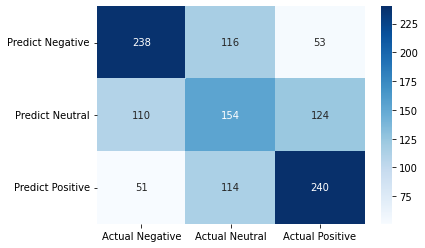

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### naive bayes classifier

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,gnb.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,gnb.predict(X_test)),4)))

Training Accuracy score: 0.9333
Testing Accuracy score: 0.4425


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.49      0.48      0.48       407
     neutral       0.35      0.35      0.35       388
    negative       0.49      0.49      0.49       405

    accuracy                           0.44      1200
   macro avg       0.44      0.44      0.44      1200
weighted avg       0.44      0.44      0.44      1200



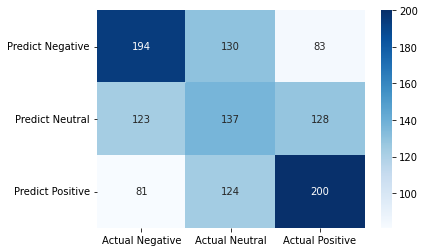

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### logistic regression

In [ ]:
lr = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,lr.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,lr.predict(X_test)),4)))

Training Accuracy score: 0.9019
Testing Accuracy score: 0.7367


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.77      0.81      0.79       407
     neutral       0.64      0.59      0.61       388
    negative       0.79      0.80      0.80       405

    accuracy                           0.74      1200
   macro avg       0.73      0.73      0.73      1200
weighted avg       0.73      0.74      0.73      1200



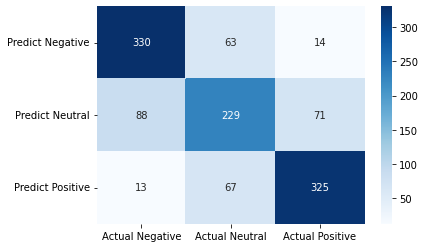

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### random forest classifier

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,clf.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,clf.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.7083


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.73      0.81      0.77       407
     neutral       0.63      0.54      0.58       388
    negative       0.75      0.77      0.76       405

    accuracy                           0.71      1200
   macro avg       0.70      0.71      0.70      1200
weighted avg       0.70      0.71      0.70      1200



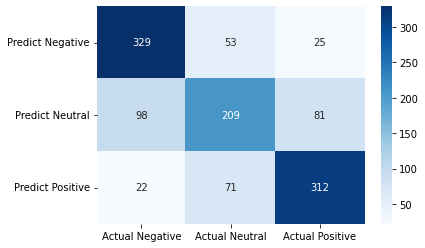

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

# -------------------------------------------------------------

# load raw dataset and prepare simple train and test predict dataset - MANY (tfidf max feature 50000)

In [ ]:
raw = pd.read_csv('tripadvisor_hotel_reviews.csv')
raw.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
raw['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [ ]:
raw1 = raw

positive = [4, 5]
negative = [1, 2]
neutral = [3]

def sentiment(rating):
  if rating in positive:
    return 1
  elif rating in negative:
    return -1
  else:
    return 0

raw1['Sentiment'] = raw1['Rating'].apply(sentiment)
raw1.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,-1
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


In [ ]:
raw1['Rating'] = raw1['Rating'].astype(str)
raw1_rt1 = raw1[raw1['Rating'].isin(['1'])]
raw1_rt2 = raw1[raw1['Rating'].isin(['2'])]
raw1_rt3 = raw1[raw1['Rating'].isin(['3'])]
raw1_rt4 = raw1[raw1['Rating'].isin(['4'])]
raw1_rt5 = raw1[raw1['Rating'].isin(['5'])]

In [ ]:
rprep1_train = raw1_rt1.sample(n = 1000, random_state = 2)
rprep2_train = raw1_rt2.sample(n = 1000, random_state = 2)
rprep3_train = raw1_rt3.sample(n = 2000, random_state = 2)
rprep4_train = raw1_rt4.sample(n = 1000, random_state = 2)
rprep5_train = raw1_rt5.sample(n = 1000, random_state = 2)
prepframelist_train = [rprep1_train, rprep2_train, rprep3_train, rprep4_train, rprep5_train]
simple_train_ready = pd.concat(prepframelist_train)

train_exclude = raw1[~raw1['Review'].isin(simple_train_ready['Review'])]

simple_train_ready = simple_train_ready.reset_index(drop=True)

In [ ]:
train_exclude['Rating'].value_counts()

5    8054
4    5039
2     793
1     421
3     184
Name: Rating, dtype: int64

In [ ]:
train_exclude['Rating'] = train_exclude['Rating'].astype(str)
train_exclude_rt1 = train_exclude[train_exclude['Rating'].isin(['1'])]
train_exclude_rt2 = train_exclude[train_exclude['Rating'].isin(['2'])]
train_exclude_rt3 = train_exclude[train_exclude['Rating'].isin(['3'])]
train_exclude_rt4 = train_exclude[train_exclude['Rating'].isin(['4'])]
train_exclude_rt5 = train_exclude[train_exclude['Rating'].isin(['5'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
rprep1_test = train_exclude_rt1.sample(n = 3, random_state = 7)
rprep2_test = train_exclude_rt2.sample(n = 3, random_state = 7)
rprep3_test = train_exclude_rt3.sample(n = 8, random_state = 7)
rprep4_test = train_exclude_rt4.sample(n = 3, random_state = 7)
rprep5_test = train_exclude_rt5.sample(n = 3, random_state = 7)
prepframelist_test = [rprep1_test, rprep2_test, rprep3_test, rprep4_test, rprep5_test]

simple_test_master_ready = pd.concat(prepframelist_test)
simple_test_master_ready = simple_test_master_ready.reset_index(drop=True)

In [ ]:
simple_train_ready = simple_train_ready.drop(['Rating'], axis=1)
simple_train_ready.to_csv('train.csv', index=False)
simple_test_master_ready = simple_test_master_ready.drop(['Rating'], axis=1)
simple_test_master_ready.to_csv('test_master.csv', index=False)
simple_test_ready = simple_test_master_ready.drop(['Sentiment'], axis=1)
simple_test_ready.to_csv('test.csv', index=False)

In [ ]:
simple_train_ready.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


In [ ]:
simple_test_master_ready.head()

,Review,Sentiment
0,stay away hotel experience hotel great disappo...,-1
1,poor management husband staying summerfield su...,-1
2,"dump, hotel did good reviews stay, just checke...",-1
3,confusing disorganized property travelers real...,-1
4,"germans, fantastic resort just expected great ...",-1


In [ ]:
simple_test_ready.head()

,Review
0,stay away hotel experience hotel great disappo...
1,poor management husband staying summerfield su...
2,"dump, hotel did good reviews stay, just checke..."
3,confusing disorganized property travelers real...
4,"germans, fantastic resort just expected great ..."


# data preprocessing

In [ ]:
train = pd.read_csv('train.csv')
test_prediction = pd.read_csv('test_master.csv')

In [ ]:
train.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     6000 non-null   object
 1   Sentiment  6000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 93.9+ KB


In [ ]:
train.describe()

,Sentiment
count,6000.000000
mean,0.000000
std,0.816565
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
fig = go.Figure([go.Bar(x=train.Sentiment.value_counts().index, y=train.Sentiment.value_counts().tolist(), width=0.75)])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values",
    width=500)
fig.show()

In [ ]:
test_prediction.head()

,Review,Sentiment
0,stay away hotel experience hotel great disappo...,-1
1,poor management husband staying summerfield su...,-1
2,"dump, hotel did good reviews stay, just checke...",-1
3,confusing disorganized property travelers real...,-1
4,"germans, fantastic resort just expected great ...",-1


### 1. expand contractions

In [ ]:
train2 = train
train2['Review'] = train2['Review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
train2['Review'] = [' '.join(map(str, l)) for l in train2['Review']]
train2.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


### 2. case folding, lowercasing

In [ ]:
train3 = train2
train3["Review"] = train3["Review"].str.lower()
train3.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june 6-7 power w...",-1
3,service slower public transport star prices 1 ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


### 3. remove number

In [ ]:
train4 = train3
train4['Review'] = train4['Review'].apply(lambda x: re.sub("[0-9]", " ", x))
train4.head()

,Review,Sentiment
0,"worst vacation, just returned punta cana disap...",-1
1,"stay damp dark cold expensive room, wholeheart...",-1
2,"rating suspect, hotel sofitel june - power w...",-1
3,service slower public transport star prices ...,-1
4,"surround sound air conditioners-yikes, husband...",-1


### 4. punctuation removal

In [ ]:
train5 = train4
train5['Review'] = train5['Review'].apply(lambda x: re.sub('[%s]' % re.escape(st.punctuation), '' , x))
train5.head()

,Review,Sentiment
0,worst vacation just returned punta cana disapp...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power wat...,-1
3,service slower public transport star prices ...,-1
4,surround sound air conditionersyikes husband w...,-1


### 5. stopwords removal

In [ ]:
nltk.download('stopwords')
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [ ]:
train6 = train5
train6['Review'] = train6['Review'].apply(lambda text: remove_stopwords(text))
train6.head()

,Review,Sentiment
0,worst vacation returned punta cana disappointm...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power water ...,-1
3,service slower public transport star prices st...,-1
4,surround sound air conditionersyikes husband w...,-1


### 6. lemmatization

In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train7 = train6
train7['Review'] = train7['Review'].apply(lambda text: lemmatize_words(text))
train7.head()

,Review,Sentiment
0,worst vacation returned punta cana disappointm...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power water ...,-1
3,service slower public transport star price sta...,-1
4,surround sound air conditionersyikes husband w...,-1


### finishing preprocess

In [ ]:
train7.to_csv('train_preproc_done.csv', index=False)

# processing

In [ ]:
train_proc = pd.read_csv('train_preproc_done.csv')
train_proc.head()

,Review,Sentiment
0,worst vacation returned punta cana disappointm...,-1
1,stay damp dark cold expensive room wholehearte...,-1
2,rating suspect hotel sofitel june power water ...,-1
3,service slower public transport star price sta...,-1
4,surround sound air conditionersyikes husband w...,-1


## tf-idf

In [ ]:
docs = list(train_proc['Review'])
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 50000)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [ ]:
X = tfidf_vectorizer_vectors.toarray()
Y = train_proc['Sentiment']

In [ ]:
len(X[0])

34223

#### split dataset to train and validation

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=51)

## classification

In [ ]:
RANDOM_SEED=51

### decision tree classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.5458


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.62      0.61      0.61       407
     neutral       0.44      0.41      0.42       388
    negative       0.57      0.62      0.59       405

    accuracy                           0.55      1200
   macro avg       0.54      0.54      0.54      1200
weighted avg       0.54      0.55      0.54      1200



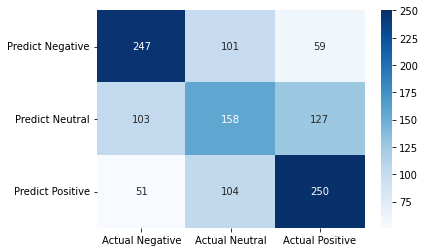

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### naive bayes classifier

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,gnb.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,gnb.predict(X_test)),4)))

Training Accuracy score: 0.9531
Testing Accuracy score: 0.44


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.49      0.46      0.48       407
     neutral       0.35      0.35      0.35       388
    negative       0.48      0.50      0.49       405

    accuracy                           0.44      1200
   macro avg       0.44      0.44      0.44      1200
weighted avg       0.44      0.44      0.44      1200



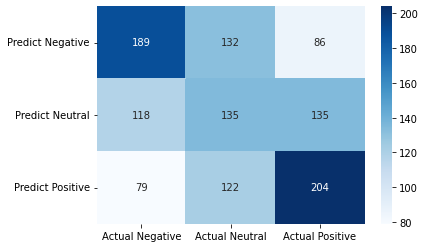

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### logistic regression

In [ ]:
lr = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,lr.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,lr.predict(X_test)),4)))

Training Accuracy score: 0.9098
Testing Accuracy score: 0.7383


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.76      0.82      0.79       407
     neutral       0.65      0.58      0.61       388
    negative       0.79      0.80      0.80       405

    accuracy                           0.74      1200
   macro avg       0.73      0.74      0.73      1200
weighted avg       0.73      0.74      0.74      1200



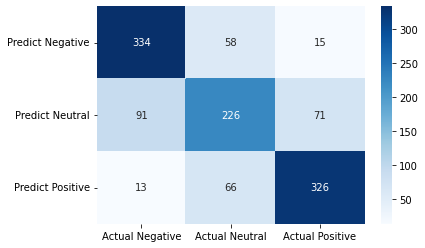

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### random forest classifier

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,clf.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,clf.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.6867


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.71      0.81      0.75       407
     neutral       0.61      0.46      0.53       388
    negative       0.71      0.78      0.75       405

    accuracy                           0.69      1200
   macro avg       0.68      0.68      0.68      1200
weighted avg       0.68      0.69      0.68      1200



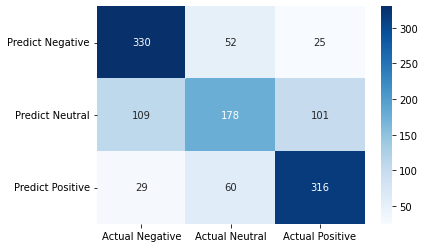

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

# -----------------------------------------------------------------